# Package installations and imports  

In [ ]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


# Data Preparation

## Vegetable Dataset

From vegetable production to delivery, several common steps are operated manually like picking, and sorting vegetables. The initial experiment is done with 15 types of common vegetables that are found throughout the world. The vegetables that are chosen for the experimentation are- bean, bitter gourd, bottle gourd, brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato. A total of 21000 images from 15 classes are used where each class contains 1400 images of size 224×224 and in *.jpg format. The dataset split 70% for training, 15% for validation, and 15% for testing purpose.

## Download and unzip the dataset

In [ ]:
# train_set
!gdown https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY

# val_set
!gdown https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP

# test_set
!gdown https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH

Downloading...
From: https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY
To: /content/vegetable_train.zip
100% 399M/399M [00:02<00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP
To: /content/vegetable_test.zip
100% 80.3M/80.3M [00:00<00:00, 230MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH
To: /content/vegetable_validation.zip
100% 79.6M/79.6M [00:00<00:00, 292MB/s]


In [ ]:
%%capture
!unzip /content/vegetable_train.zip;
!unzip /content/vegetable_validation.zip;
!unzip /content/vegetable_test.zip;

## Loading the train, val and test sets from their respective folders

### Initializing ImageFolder (dataset) Instances

In [ ]:
image_size = 90

initialize train_set

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((image_size,image_size))])

train_data_path = '/content/vegetable_train'

train_set = dummy_train_set = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# dummy_train_set is initialized for keeping a copy of train_set
# for demonstration of data augmentation

initialize val_set

In [ ]:
val_data_path = '/content/vegetable_validation'

val_set = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform)

initialize test_set

In [ ]:
test_data_path = '/content/vegetable_test'

test_set = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)

### Attributes of the ImageFolder (dataset) objects (train_set)

In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: /content/vegetable_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
           )

In [ ]:
len(train_set.imgs)

15000

In [ ]:
# Class to num of instances
# caution: takes some time to run
class_counts = np.zeros(len(train_set.class_to_idx))
for image, label in train_set:
    class_counts[label] += 1
for i in range(len(class_counts)):
  print("class:%s, instances: %d"%([k for k,v in train_set.class_to_idx.items() if v == i], class_counts[i]))

class:['Bean'], instances: 1000
class:['Bitter_Gourd'], instances: 1000
class:['Bottle_Gourd'], instances: 1000
class:['Brinjal'], instances: 1000
class:['Broccoli'], instances: 1000
class:['Cabbage'], instances: 1000
class:['Capsicum'], instances: 1000
class:['Carrot'], instances: 1000
class:['Cauliflower'], instances: 1000
class:['Cucumber'], instances: 1000
class:['Papaya'], instances: 1000
class:['Potato'], instances: 1000
class:['Pumpkin'], instances: 1000
class:['Radish'], instances: 1000
class:['Tomato'], instances: 1000


## Function for visualizing images of dataset object

In [ ]:
def show_dataset_samples(data_set):
    loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=32,
    shuffle=True)

  # Get a batch of images from the train_loader
    images, labels = next(iter(loader))

    rows = col = 3
    #fig, axes = plt.subplots(nrows=5, ncols=5)                          )
    plt.figure(figsize = (10,10))

    for i in range(rows*col):
      # Plot a random image from the batch
      random_index = np.random.randint(0, images.shape[0])
      image = images[random_index]
      label = labels[random_index]
      plt.subplot(rows, col, i+1)
      plt.axis('off')
      plt.imshow(image.permute(1,2,0))
      plt.title(f'Label: {train_set.classes[label]}')

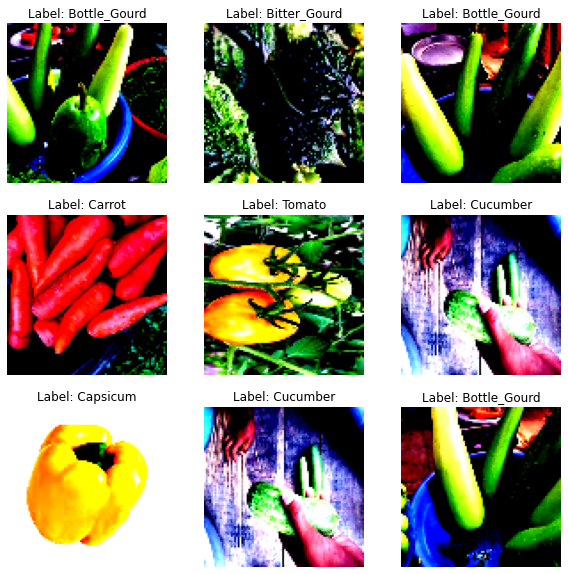

In [ ]:
show_dataset_samples(train_set)

## Compute Normalization parameters from the train_set and apply them to train, validation and test

### Compute Mean and Standard Deviation for train_set for each channel R, G and B

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Source:
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
#

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/vegetable_train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32)

In [ ]:
mean, std = get_mean_and_std(dataloader)

In [ ]:
mean, std

(tensor([-4.4227e-07, -1.1163e-06, -1.5924e-07]),
 tensor([1.0000, 1.0000, 1.0000]))

### Add the new normalization to the existing transforms

In [ ]:
# Add the new normalization to the existing transforms
normalize = torchvision.transforms.Normalize(mean=mean, std=std)
transform = torchvision.transforms.Compose([transform, normalize]) # combining both transforms into a single tranformation

# Apply the normalization transform to the datasets
train_set.transform = transform # replace the current transform into the new one
val_set.transform = transform
test_set.transform = transform

In [ ]:
train_set.transform

Compose(
    Compose(
    Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
)
    Normalize(mean=tensor([0.4689, 0.4635, 0.3433]), std=tensor([0.2327, 0.2274, 0.2420]))
)
    Normalize(mean=tensor([-4.4227e-07, -1.1163e-06, -1.5924e-07]), std=tensor([1.0000, 1.0000, 1.0000]))
)

### Visualize the images with the new normalization transform

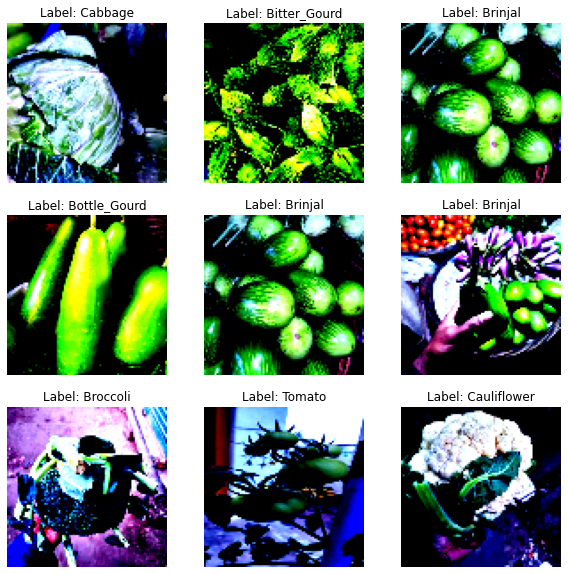

In [ ]:
show_dataset_samples(train_set)

## Data Augmentation

1. RandomRotation
2. RandomFlip
  1. RandomHorizontalFlip
  2. RandomVerticalFlip
3. GaussianBlur

Refer to the links below for a list of available pre-built data augmentation techniques and their illustrations that you can use.

https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

https://pytorch.org/vision/main/transforms.html

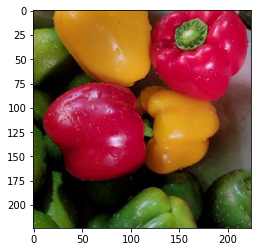

In [ ]:
orig_img = Image.open('/content/vegetable_train/Capsicum/0005.jpg')
plt.imshow(orig_img)

### Random Rotation

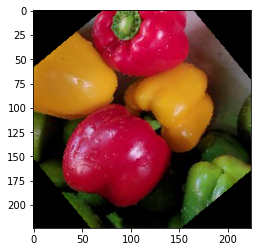

In [ ]:
random_rotation = torchvision.transforms.RandomRotation(45)
plt.imshow(random_rotation(orig_img))

### RandomFlip

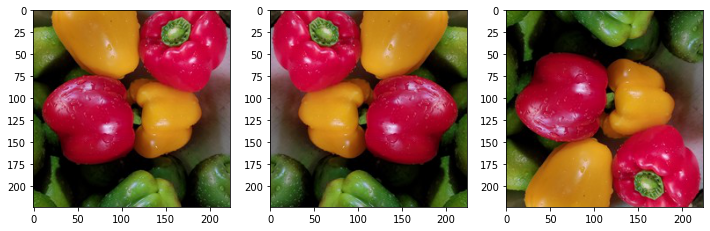

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.imshow(orig_img)

random_flip = torchvision.transforms.RandomHorizontalFlip(1)
plt.subplot(1,3,2)
plt.imshow(random_flip(orig_img))


random_flip = torchvision.transforms.RandomVerticalFlip(1)
plt.subplot(1,3,3)
plt.imshow(random_flip(orig_img))

### GaussianBlur

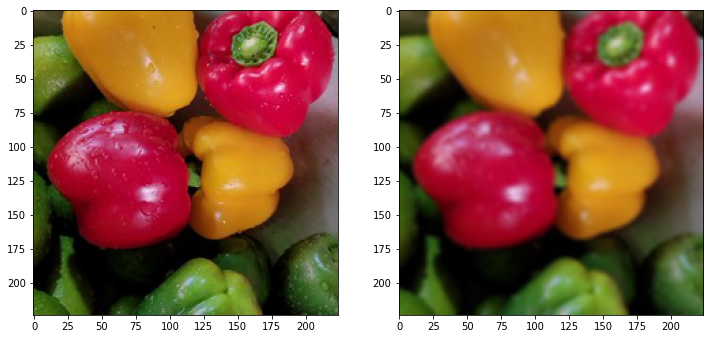

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(orig_img)

GB = torchvision.transforms.GaussianBlur(5,2)
plt.subplot(1,2,2)
plt.imshow(GB(orig_img))

### Applying all the augmentations combined

In [ ]:
augmentation_transforms = torchvision.transforms.Compose([transform,
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.GaussianBlur(5)
    ])
dummy_train_set.transform = augmentation_transforms
dummy_train_set.transform

Compose(
    Compose(
    Compose(
    Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
)
    Normalize(mean=tensor([0.4689, 0.4635, 0.3433]), std=tensor([0.2327, 0.2274, 0.2420]))
)
    Normalize(mean=tensor([-4.4227e-07, -1.1163e-06, -1.5924e-07]), std=tensor([1.0000, 1.0000, 1.0000]))
)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
)

## Initializing the pytorch dataloaders and visualize train examples

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=128,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=False
)


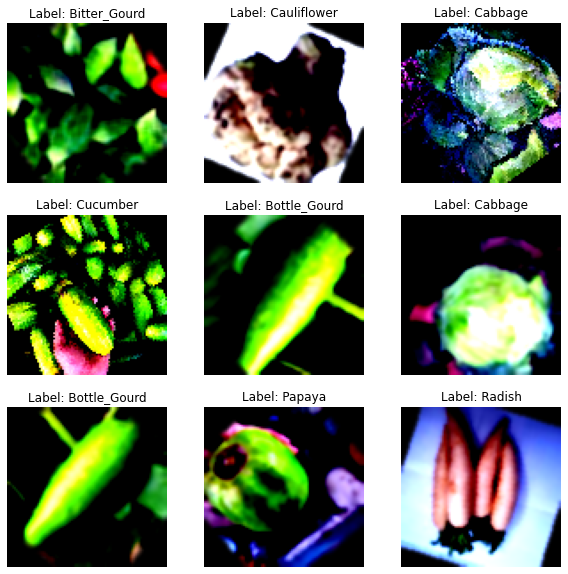

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(train_loader))

rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)                          )
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {train_set.classes[label]}')

# Convolutional Neural Networks

## The AlexNet Model (2012)

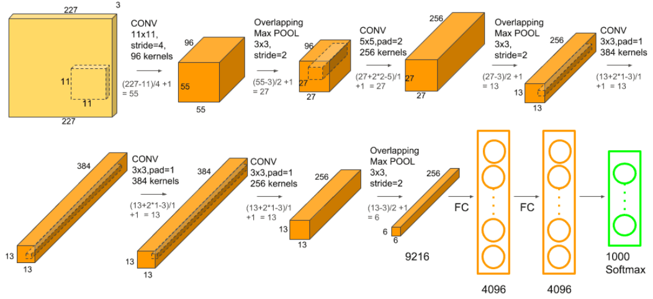

In [ ]:
# This model is designed such that it will take only image of size 227x227
# So set the image_size = 227 at the start to run this model
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Source: https://blog.paperspace.com/alexnet-pytorch/

In [ ]:
dummy_model = AlexNet().to(device)
summary(dummy_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

## VGG-16
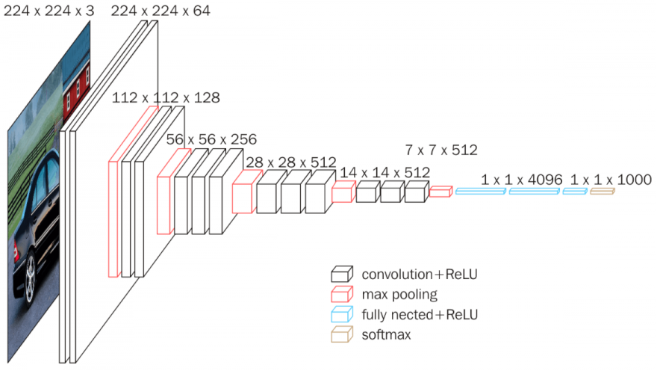

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=15, im_height=224, im_width=224):

        super(VGG16, self).__init__()

        max_pool_count = 5
        size_reduction_factor = 2**max_pool_count
        out_height = im_height // size_reduction_factor
        out_width = im_width // size_reduction_factor

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_height*out_width*512, 4096),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Source: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [ ]:
dummy_model = VGG16(num_classes=15, im_height=image_size, im_width=image_size).to(device)
summary(dummy_model, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 90, 90]           1,792
       BatchNorm2d-2           [-1, 64, 90, 90]             128
              ReLU-3           [-1, 64, 90, 90]               0
            Conv2d-4           [-1, 64, 90, 90]          36,928
       BatchNorm2d-5           [-1, 64, 90, 90]             128
              ReLU-6           [-1, 64, 90, 90]               0
         MaxPool2d-7           [-1, 64, 45, 45]               0
            Conv2d-8          [-1, 128, 45, 45]          73,856
       BatchNorm2d-9          [-1, 128, 45, 45]             256
             ReLU-10          [-1, 128, 45, 45]               0
           Conv2d-11          [-1, 128, 45, 45]         147,584
      BatchNorm2d-12          [-1, 128, 45, 45]             256
             ReLU-13          [-1, 128, 45, 45]               0
        MaxPool2d-14          [-1, 128,

## ResNet-18

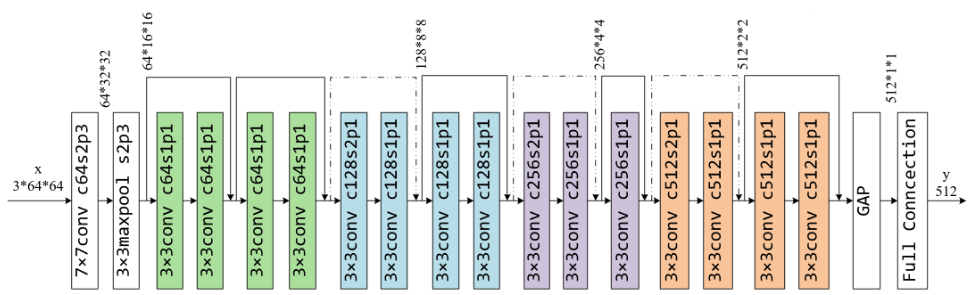

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=15):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten() # torch.flatten doesnt work here! just a note for the future!
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)

        input = self.layer1(input)

        input = self.layer2(input)

        input = self.layer3(input)

        input = self.layer4(input)

        input = self.gap(input)

        input = self.flatten(input)
        #input = input.view(input.size(0), -1)

        input = self.fc(input)

        return input

#Source: https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

In [ ]:
dummy_model = ResNet18(3, ResBlock, 15).to(device)
summary(dummy_model, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 45, 45]           9,472
         MaxPool2d-2           [-1, 64, 23, 23]               0
       BatchNorm2d-3           [-1, 64, 23, 23]             128
              ReLU-4           [-1, 64, 23, 23]               0
            Conv2d-5           [-1, 64, 23, 23]          36,928
       BatchNorm2d-6           [-1, 64, 23, 23]             128
            Conv2d-7           [-1, 64, 23, 23]          36,928
       BatchNorm2d-8           [-1, 64, 23, 23]             128
          ResBlock-9           [-1, 64, 23, 23]               0
           Conv2d-10           [-1, 64, 23, 23]          36,928
      BatchNorm2d-11           [-1, 64, 23, 23]             128
           Conv2d-12           [-1, 64, 23, 23]          36,928
      BatchNorm2d-13           [-1, 64, 23, 23]             128
         ResBlock-14           [-1, 64,

## The simple convolutional model from Lab 1

In [ ]:
num_classes = 15
model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            Linear(32 * 5 * 5, num_classes)
        )

model.to(device);

In [ ]:
dummy_model = model.to(device)
summary(dummy_model, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 90, 90]             112
       BatchNorm2d-2            [-1, 4, 90, 90]               8
              ReLU-3            [-1, 4, 90, 90]               0
         MaxPool2d-4            [-1, 4, 45, 45]               0
            Conv2d-5            [-1, 8, 45, 45]             296
       BatchNorm2d-6            [-1, 8, 45, 45]              16
              ReLU-7            [-1, 8, 45, 45]               0
         MaxPool2d-8            [-1, 8, 22, 22]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
           Conv2d-13           [-1, 32, 11, 11]           4,640
      BatchNorm2d-14           [-1, 32,

## A single layer model for quickly running loops

In [ ]:
# A dummy single layer model to quickly traverse training loops
num_classes = 15
model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            nn.Flatten(),
            Linear(4 * image_size * image_size, num_classes)
        )

model.to(device);

In [ ]:
dummy_model = model.to(device)
summary(dummy_model, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 90, 90]             112
       BatchNorm2d-2            [-1, 4, 90, 90]               8
              ReLU-3            [-1, 4, 90, 90]               0
           Flatten-4                [-1, 32400]               0
            Linear-5                   [-1, 15]         486,015
Total params: 486,135
Trainable params: 486,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.99
Params size (MB): 1.85
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


# Model Configuration

### Initialize AlexNet Model

In [ ]:
# Initialize the model
model = AlexNet(num_classes=15)
model.to(device);

### Initialize VGG16 Model

In [ ]:
model = VGG16(num_classes=15, im_height= 224, im_width= 224)
model.to(device);

## Initialize ResNet18

In [ ]:
model = ResNet18(3, ResBlock, 15).to(device)

### Loss Function and Optimizer Selection

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()  # applies the softmax at the output intrinsically

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 80

# Training Loop

In [ ]:
def run_1_epoch(model, loss_fn, optimizer, loader, train = False):


  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0

  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset.imgs)

  # number of batches we can get by the loader
  total_batches_in_loader = len(loader)



  for image_batch, labels in tqdm(loader):

    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)

    # Zeroing out the gradients for parameters
    if train:
      optimizer.zero_grad()

    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows

    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()

    # Update the parameters using the gradients
    if train:
      optimizer.step()

    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy

### Define a function for running a model over all the samples of a given dataloader object

### Main training loop

In [ ]:
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []

val_accuracy_max = -1

In [ ]:
# Main training and validation loop for n number of epochs
for i in range(epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(i, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, optimizer, train_loader, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(i))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, optimizer, val_loader, train= False)

  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New Max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))
    torch.save(model,'best_val_acc_model.pth')
  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))


Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 0: Validation


100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


train loss: 1.0607
val loss: 0.9248
train_accuracy 64.89
val_accuracy 70.43
New Max val Accuracy Acheived 70.43. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:12<00:00,  1.63it/s]


Epoch 1: Validation


100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


train loss: 0.5207
val loss: 0.5286
train_accuracy 82.75
val_accuracy 83.27
New Max val Accuracy Acheived 83.27. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 2: Validation


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


train loss: 0.3582
val loss: 0.4291
train_accuracy 88.17
val_accuracy 86.30
New Max val Accuracy Acheived 86.30. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.76it/s]


Epoch 3: Validation


100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


train loss: 0.2963
val loss: 0.3854
train_accuracy 90.17
val_accuracy 87.50
New Max val Accuracy Acheived 87.50. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 4: Validation


100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


train loss: 0.2265
val loss: 0.3145
train_accuracy 92.75
val_accuracy 90.10
New Max val Accuracy Acheived 90.10. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:13<00:00,  1.61it/s]


Epoch 5: Validation


100%|██████████| 24/24 [00:08<00:00,  2.91it/s]


train loss: 0.2078
val loss: 0.2575
train_accuracy 93.36
val_accuracy 91.53
New Max val Accuracy Acheived 91.53. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:11<00:00,  1.65it/s]


Epoch 6: Validation


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


train loss: 0.1729
val loss: 0.3850
train_accuracy 94.31
val_accuracy 88.73
val accuracy did not increase from 91.53


Epoch 7: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:09<00:00,  1.71it/s]


Epoch 7: Validation


100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


train loss: 0.1589
val loss: 0.1773
train_accuracy 95.12
val_accuracy 95.10
New Max val Accuracy Acheived 95.10. Saving model.


Epoch 8: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.76it/s]


Epoch 8: Validation


100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


train loss: 0.1439
val loss: 0.2359
train_accuracy 95.53
val_accuracy 92.50
val accuracy did not increase from 95.10


Epoch 9: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 9: Validation


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


train loss: 0.1136
val loss: 0.3465
train_accuracy 96.55
val_accuracy 88.93
val accuracy did not increase from 95.10


Epoch 10: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 10: Validation


100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


train loss: 0.1274
val loss: 0.1578
train_accuracy 96.01
val_accuracy 95.23
New Max val Accuracy Acheived 95.23. Saving model.


Epoch 11: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.77it/s]


Epoch 11: Validation


100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


train loss: 0.1170
val loss: 0.1754
train_accuracy 96.33
val_accuracy 94.73
val accuracy did not increase from 95.23


Epoch 12: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.76it/s]


Epoch 12: Validation


100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


train loss: 0.1076
val loss: 0.1321
train_accuracy 96.67
val_accuracy 96.20
New Max val Accuracy Acheived 96.20. Saving model.


Epoch 13: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.77it/s]


Epoch 13: Validation


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


train loss: 0.0790
val loss: 0.1062
train_accuracy 97.67
val_accuracy 96.93
New Max val Accuracy Acheived 96.93. Saving model.


Epoch 14: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch 14: Validation


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


train loss: 0.0836
val loss: 0.1429
train_accuracy 97.28
val_accuracy 96.17
val accuracy did not increase from 96.93


Epoch 15: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch 15: Validation


100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


train loss: 0.0958
val loss: 0.1943
train_accuracy 96.94
val_accuracy 93.67
val accuracy did not increase from 96.93


Epoch 16: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 16: Validation


100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


train loss: 0.0681
val loss: 0.2349
train_accuracy 97.85
val_accuracy 93.17
val accuracy did not increase from 96.93


Epoch 17: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.77it/s]


Epoch 17: Validation


100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


train loss: 0.0665
val loss: 0.0955
train_accuracy 97.94
val_accuracy 97.47
New Max val Accuracy Acheived 97.47. Saving model.


Epoch 18: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 18: Validation


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


train loss: 0.0677
val loss: 0.0948
train_accuracy 97.61
val_accuracy 97.20
val accuracy did not increase from 97.47


Epoch 19: Train 
Learning Rate: 0.001000


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch 19: Validation


100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


train loss: 0.0723
val loss: 0.2449
train_accuracy 97.79
val_accuracy 93.83
val accuracy did not increase from 97.47


Epoch 20: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 20: Validation


100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


train loss: 0.0259
val loss: 0.0370
train_accuracy 99.13
val_accuracy 99.13
New Max val Accuracy Acheived 99.13. Saving model.


Epoch 21: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 21: Validation


100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


train loss: 0.0195
val loss: 0.0341
train_accuracy 99.52
val_accuracy 99.13
val accuracy did not increase from 99.13


Epoch 22: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 22: Validation


100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


train loss: 0.0157
val loss: 0.0353
train_accuracy 99.60
val_accuracy 99.10
val accuracy did not increase from 99.13


Epoch 23: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Epoch 23: Validation


100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


train loss: 0.0104
val loss: 0.0355
train_accuracy 99.76
val_accuracy 99.10
val accuracy did not increase from 99.13


Epoch 24: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:09<00:00,  1.70it/s]


Epoch 24: Validation


100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


train loss: 0.0123
val loss: 0.0342
train_accuracy 99.67
val_accuracy 99.10
val accuracy did not increase from 99.13


Epoch 25: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 25: Validation


100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


train loss: 0.0112
val loss: 0.0373
train_accuracy 99.70
val_accuracy 99.07
val accuracy did not increase from 99.13


Epoch 26: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 26: Validation


100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


train loss: 0.0100
val loss: 0.0335
train_accuracy 99.77
val_accuracy 99.20
New Max val Accuracy Acheived 99.20. Saving model.


Epoch 27: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 27: Validation


100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


train loss: 0.0116
val loss: 0.0327
train_accuracy 99.65
val_accuracy 99.17
val accuracy did not increase from 99.20


Epoch 28: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 28: Validation


100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


train loss: 0.0081
val loss: 0.0327
train_accuracy 99.82
val_accuracy 99.20
val accuracy did not increase from 99.20


Epoch 29: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 29: Validation


100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


train loss: 0.0077
val loss: 0.0374
train_accuracy 99.83
val_accuracy 99.00
val accuracy did not increase from 99.20


Epoch 30: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 30: Validation


100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


train loss: 0.0077
val loss: 0.0360
train_accuracy 99.81
val_accuracy 99.20
val accuracy did not increase from 99.20


Epoch 31: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 31: Validation


100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


train loss: 0.0074
val loss: 0.0372
train_accuracy 99.81
val_accuracy 99.13
val accuracy did not increase from 99.20


Epoch 32: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 32: Validation


100%|██████████| 24/24 [00:06<00:00,  3.66it/s]


train loss: 0.0075
val loss: 0.0321
train_accuracy 99.82
val_accuracy 99.17
val accuracy did not increase from 99.20


Epoch 33: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 33: Validation


100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


train loss: 0.0074
val loss: 0.0326
train_accuracy 99.84
val_accuracy 99.13
val accuracy did not increase from 99.20


Epoch 34: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 34: Validation


100%|██████████| 24/24 [00:06<00:00,  3.62it/s]


train loss: 0.0070
val loss: 0.0335
train_accuracy 99.85
val_accuracy 99.17
val accuracy did not increase from 99.20


Epoch 35: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 35: Validation


100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


train loss: 0.0089
val loss: 0.0320
train_accuracy 99.77
val_accuracy 99.23
New Max val Accuracy Acheived 99.23. Saving model.


Epoch 36: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 36: Validation


100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


train loss: 0.0080
val loss: 0.0366
train_accuracy 99.80
val_accuracy 99.27
New Max val Accuracy Acheived 99.27. Saving model.


Epoch 37: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 37: Validation


100%|██████████| 24/24 [00:06<00:00,  3.70it/s]


train loss: 0.0062
val loss: 0.0345
train_accuracy 99.87
val_accuracy 99.23
val accuracy did not increase from 99.27


Epoch 38: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 38: Validation


100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


train loss: 0.0076
val loss: 0.0349
train_accuracy 99.91
val_accuracy 99.23
val accuracy did not increase from 99.27


Epoch 39: Train 
Learning Rate: 0.000100


100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Epoch 39: Validation


100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


train loss: 0.0096
val loss: 0.0322
train_accuracy 99.69
val_accuracy 99.30
New Max val Accuracy Acheived 99.30. Saving model.


Epoch 40: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:09<00:00,  1.69it/s]


Epoch 40: Validation


100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


train loss: 0.0055
val loss: 0.0308
train_accuracy 99.89
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 41: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 41: Validation


100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


train loss: 0.0046
val loss: 0.0338
train_accuracy 99.89
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 42: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 42: Validation


100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


train loss: 0.0060
val loss: 0.0295
train_accuracy 99.90
val_accuracy 99.20
val accuracy did not increase from 99.30


Epoch 43: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 43: Validation


100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


train loss: 0.0052
val loss: 0.0301
train_accuracy 99.86
val_accuracy 99.20
val accuracy did not increase from 99.30


Epoch 44: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 44: Validation


100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


train loss: 0.0049
val loss: 0.0320
train_accuracy 99.88
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 45: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


Epoch 45: Validation


100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


train loss: 0.0038
val loss: 0.0302
train_accuracy 99.92
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 46: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 46: Validation


100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


train loss: 0.0049
val loss: 0.0312
train_accuracy 99.89
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 47: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.75it/s]


Epoch 47: Validation


100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


train loss: 0.0038
val loss: 0.0284
train_accuracy 99.93
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 48: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:18<00:00,  1.50it/s]


Epoch 48: Validation


100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


train loss: 0.0079
val loss: 0.0293
train_accuracy 99.91
val_accuracy 99.20
val accuracy did not increase from 99.30


Epoch 49: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 49: Validation


100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


train loss: 0.0034
val loss: 0.0314
train_accuracy 99.92
val_accuracy 99.30
val accuracy did not increase from 99.30


Epoch 50: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch 50: Validation


100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


train loss: 0.0057
val loss: 0.0302
train_accuracy 99.90
val_accuracy 99.30
val accuracy did not increase from 99.30


Epoch 51: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Epoch 51: Validation


100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


train loss: 0.0031
val loss: 0.0326
train_accuracy 99.95
val_accuracy 99.27
val accuracy did not increase from 99.30


Epoch 52: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:09<00:00,  1.70it/s]


Epoch 52: Validation


100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


train loss: 0.0044
val loss: 0.0324
train_accuracy 99.91
val_accuracy 99.30
val accuracy did not increase from 99.30


Epoch 53: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Epoch 53: Validation


100%|██████████| 24/24 [00:06<00:00,  3.66it/s]


train loss: 0.0034
val loss: 0.0315
train_accuracy 99.95
val_accuracy 99.20
val accuracy did not increase from 99.30


Epoch 54: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 54: Validation


100%|██████████| 24/24 [00:06<00:00,  3.68it/s]


train loss: 0.0042
val loss: 0.0310
train_accuracy 99.91
val_accuracy 99.27
val accuracy did not increase from 99.30


Epoch 55: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch 55: Validation


100%|██████████| 24/24 [00:06<00:00,  3.75it/s]


train loss: 0.0031
val loss: 0.0301
train_accuracy 99.95
val_accuracy 99.30
val accuracy did not increase from 99.30


Epoch 56: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:06<00:00,  1.77it/s]


Epoch 56: Validation


100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


train loss: 0.0034
val loss: 0.0303
train_accuracy 99.93
val_accuracy 99.23
val accuracy did not increase from 99.30


Epoch 57: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch 57: Validation


100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


train loss: 0.0036
val loss: 0.0323
train_accuracy 99.95
val_accuracy 99.30
val accuracy did not increase from 99.30


Epoch 58: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch 58: Validation


100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


train loss: 0.0032
val loss: 0.0301
train_accuracy 99.93
val_accuracy 99.37
New Max val Accuracy Acheived 99.37. Saving model.


Epoch 59: Train 
Learning Rate: 0.000010


100%|██████████| 118/118 [01:05<00:00,  1.79it/s]


Epoch 59: Validation


100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


train loss: 0.0032
val loss: 0.0331
train_accuracy 99.94
val_accuracy 99.30
val accuracy did not increase from 99.37


Epoch 60: Train 
Learning Rate: 0.000001


 92%|█████████▏| 109/118 [01:01<00:05,  1.76it/s]


KeyboardInterrupt: ignored

In [ ]:
# Copy best model to drive
# You may also directly save the best model to drive during training

!cp best_val_acc_model.pth /path/to/Gdrive

cp: cannot create regular file '/path/to/Gdrive': No such file or directory


**Accuracy and Loss Result Graphs:**

Text(0.5, 1.0, 'Training and val Loss')

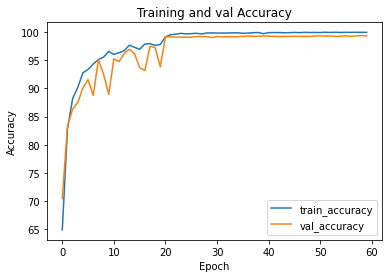

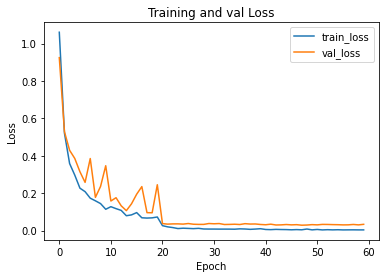

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

# Evaluating the Model

**Loading the best saved model:**

In [ ]:
best_val_model1 = torch.load('/content/best_val_acc_model.pth')

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(model, loss_function, optimizer, test_loader, train= False)

print('test loss: %.4f'%(train_loss))
print('test_accuracy %.2f' % (train_accuracy))


100%|██████████| 94/94 [00:07<00:00, 11.95it/s]

test loss: 0.0032
test_accuracy 99.94


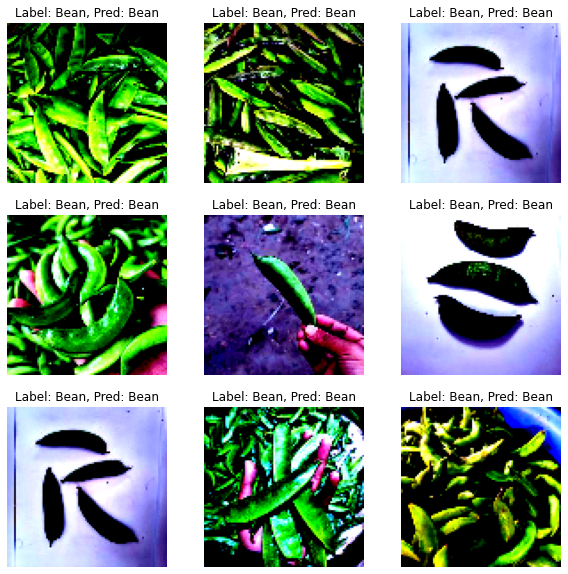

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_loader))

with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)                          )
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {test_set.classes[label]}, Pred: {test_set.classes[pred_label]}')